In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
from matplotlib import pyplot, patches
import plotly.express as px
import numpy as np
import pandas as pd
from library import tools, evals, architectures
from evaluation import deep_features_plot
import os
import pathlib
import torch
from torch.nn import functional as F

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Functions

In [2]:
def recall_pred_results(which='MultiBinary', arch='LeNet_plus_plus', dataset='SmallScale'):
    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/eval_{arch}'
    pred_results = {}
    if arch == 'LeNet_plus_plus':
        pred_results['train'] = [np.load(os.path.join(root_path, which, 'pred', 'train_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'train_logits.npy')), np.load(os.path.join(root_path, which, 'pred', 'train_feats.npy')), np.load(os.path.join(root_path, which, 'pred', 'train_probs.npy'))]
        pred_results['test_neg'] = [np.load(os.path.join(root_path, which, 'pred', 'test_neg_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_logits.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_feats.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_probs.npy'))]
        pred_results['test_unkn'] = [np.load(os.path.join(root_path, which, 'pred', 'test_unkn_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_logits.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_feats.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_probs.npy'))]
    else:
        pred_results['train'] = [np.load(os.path.join(root_path, which, 'pred', 'train_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'train_logits.npy')), None, np.load(os.path.join(root_path, which, 'pred', 'train_probs.npy'))]
        pred_results['test_neg'] = [np.load(os.path.join(root_path, which, 'pred', 'test_neg_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_logits.npy')), None, np.load(os.path.join(root_path, which, 'pred', 'test_neg_probs.npy'))]
        pred_results['test_unkn'] = [np.load(os.path.join(root_path, which, 'pred', 'test_unkn_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_logits.npy')), None, np.load(os.path.join(root_path, which, 'pred', 'test_unkn_probs.npy'))]        
    return pred_results

In [5]:
def get_net(which):
    model_root='/home/user/hkim/UZH-MT/openset-binary/_models'
    network_file = os.path.join(model_root, f"SmallScale/LeNet_plus_plus/{which}/{which}.model")

    if which == 'Garbage':
        num_classes = 11
    else:
        num_classes = 10

    net = architectures.__dict__["LeNet_plus_plus"](small_scale=True,
                                                    use_BG=False,
                                                    num_classes=num_classes,
                                                    final_layer_bias=False)
    net.load_state_dict(torch.load(network_file, map_location=torch.device('cpu')))
    return net

In [6]:
def plot_multiple_linear_functions(param_list):
    """
    Plots multiple linear functions ax + by = 1 given a list of coefficient pairs [[a1, b1], [a2, b2], ...].

    Args:
        coefficients_list (list of lists): List of coefficient pairs [[a1, b1], [a2, b2], ...].
    """
    pyplot.figure(figsize=(8, 6))
    x_values = np.linspace(-10000, 10000, 100)

    for i, coefficients in enumerate(param_list):
        a, b = coefficients
        slope = -a / b
        intercept = 1 / b
        y_values = slope * x_values + intercept
        pyplot.plot(x_values, y_values, label=f"{i}", color = pyplot.cm.tab10(i))

    pyplot.xlabel('x')
    pyplot.ylabel('y')
    pyplot.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    pyplot.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    pyplot.grid(True)
    pyplot.legend()


In [7]:
def get_stats(gt, logits, label):
    pos = gt == label
    unkn = gt == -1
    neg = ~(pos | unkn)
    
    print(f"Total: {len(gt)} \t gt=={label}: {sum(pos)} \t unkn: {sum(unkn)} \t neg: {sum(neg)}")

    pos_logits = logits[pos,label]
    unkn_logits = logits[unkn,label]
    neg_logits = logits[neg,label]

    print(f"pos_logit_min_max: {np.min(pos_logits):.2f}~{np.max(pos_logits):.2f}")
    print(f"unkn_logit_min_max: {np.min(unkn_logits):.2f}~{np.max(unkn_logits):.2f}")
    print(f"neg_logit_min_max: {np.min(neg_logits):.2f}~{np.max(neg_logits):.2f}")

    return pos_logits, unkn_logits, neg_logits

# Logit Distribution

In [7]:
which = 'MultiBinary'
dataset = 'SmallScale_fc_dim_2_bias_true'  # SmallScale    SmallScale_fc_dim_2     SmallScale_fc_dim_2_bias_true
arch = 'LeNet_plus_plus' # LeNet_plus_plus  ResNet_18

unkn_gt_label = -1
num_classes = 10

pred_results = recall_pred_results(which, arch, dataset)

# gt, logits, feats, probs = pred_results['train']
# gt, logits, feats, probs = pred_results['test_neg']
gt, logits, feats, probs = pred_results['test_unkn']

Total: 18800 	 gt==0: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -88.09~6.31
unkn_logit_min_max: -7711.26~4.76
neg_logit_min_max: -10146.68~3.22


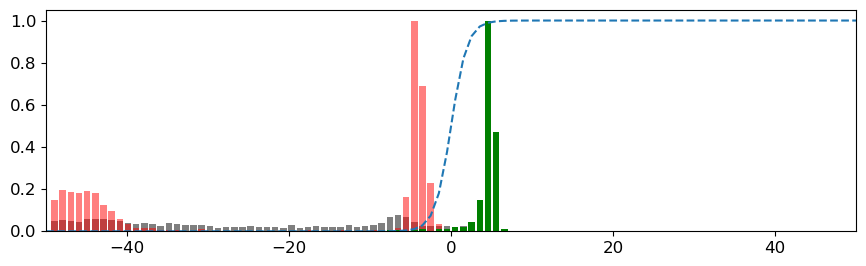

Total: 18800 	 gt==1: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -68.82~5.19
unkn_logit_min_max: -6308.51~3.72
neg_logit_min_max: -8523.96~2.66


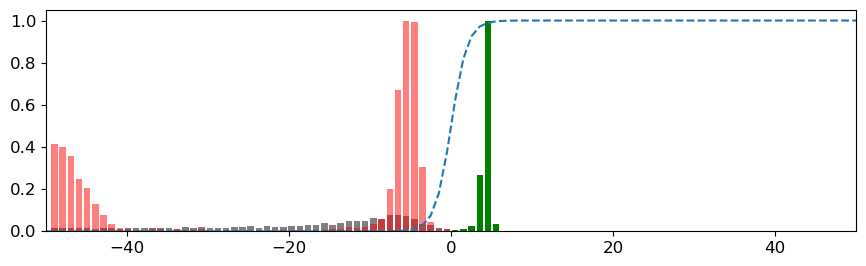

Total: 18800 	 gt==2: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -87.12~11.96
unkn_logit_min_max: -1250.96~11.93
neg_logit_min_max: -1736.38~2.07


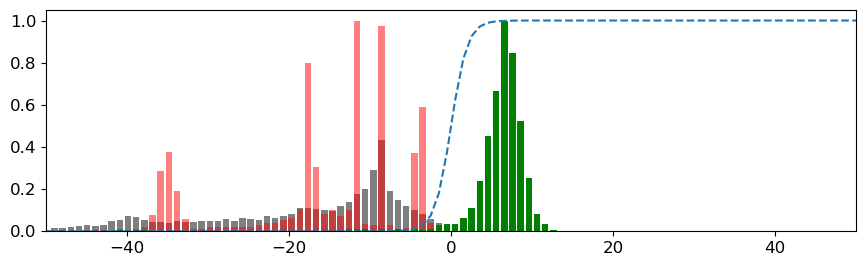

Total: 18800 	 gt==3: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -347.23~8.37
unkn_logit_min_max: -3405.66~5.58
neg_logit_min_max: -4408.82~4.01


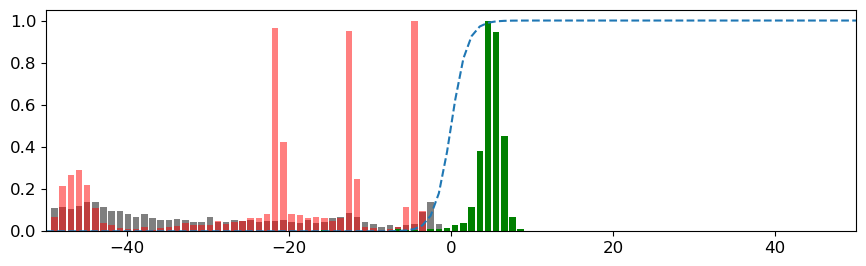

Total: 18800 	 gt==4: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -499.52~6.08
unkn_logit_min_max: -12033.34~7.03
neg_logit_min_max: -16539.47~-0.22


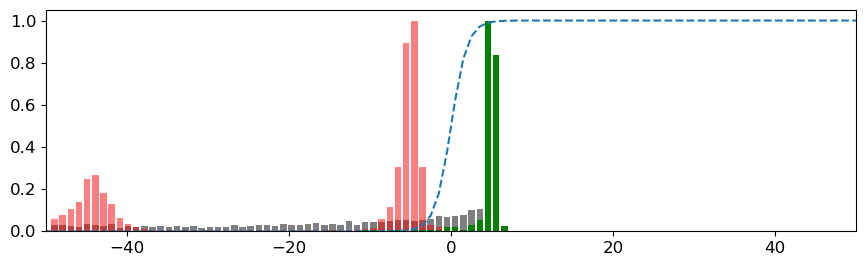

Total: 18800 	 gt==5: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -10.33~30.37
unkn_logit_min_max: -11.09~19.08
neg_logit_min_max: -11.09~-3.35


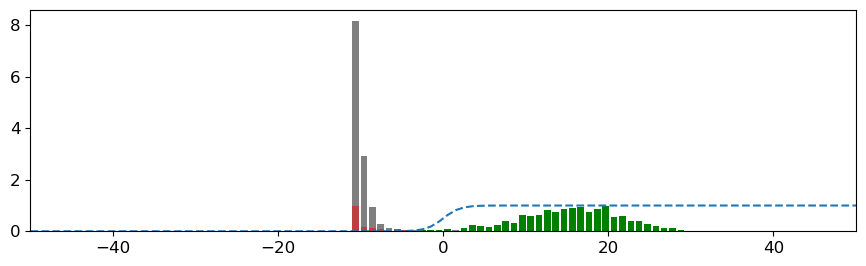

Total: 18800 	 gt==6: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -9.50~11.92
unkn_logit_min_max: -262.80~0.47
neg_logit_min_max: -322.84~-1.42


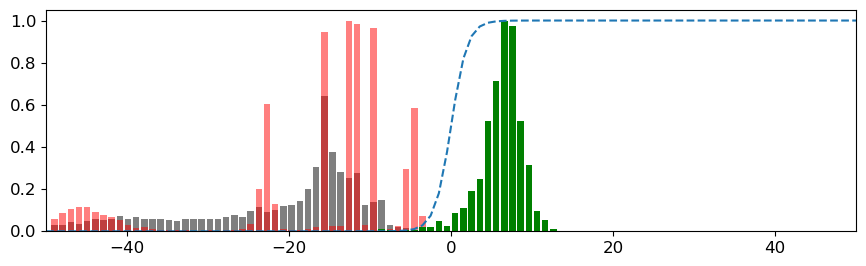

Total: 18800 	 gt==7: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -131.37~15.81
unkn_logit_min_max: -24599.56~10.80
neg_logit_min_max: -33926.81~8.66


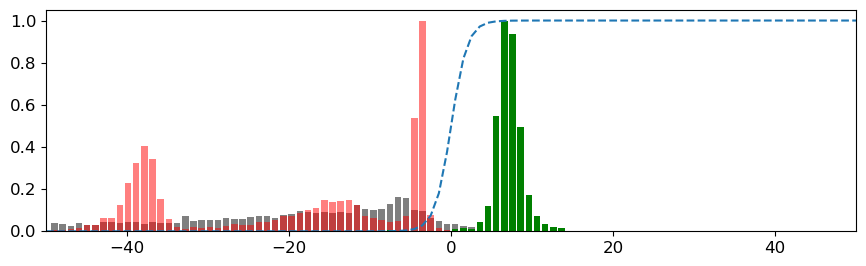

Total: 18800 	 gt==8: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -11.58~24.12
unkn_logit_min_max: -43.19~15.89
neg_logit_min_max: -46.70~-1.64


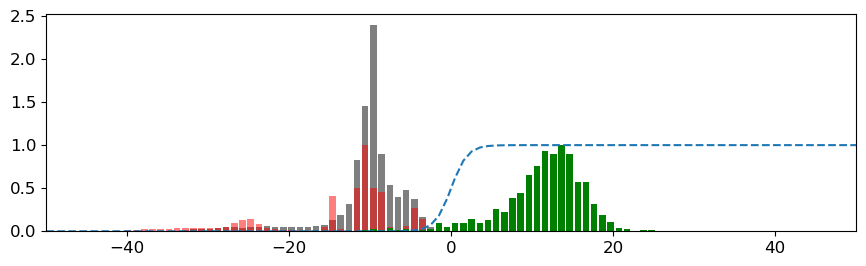

Total: 18800 	 gt==9: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -937.42~9.99
unkn_logit_min_max: -11502.72~11.11
neg_logit_min_max: -15002.46~5.56


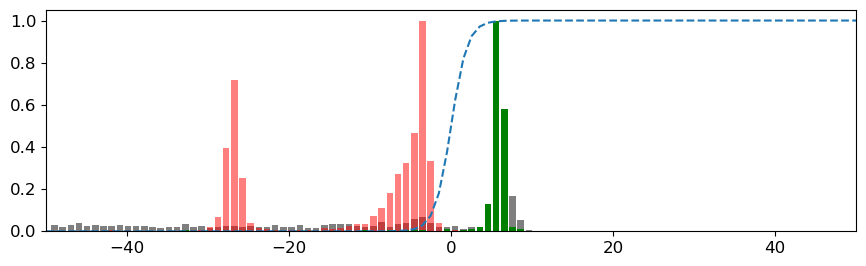

In [8]:
for i in range(10):
    label = i
    pos_logits, unkn_logits, neg_logits = get_stats(gt, logits, label)
    xrange = (-50,50)
    bins = np.linspace(xrange[0],xrange[1],100)
    pos_hist = np.histogram(pos_logits, bins=bins, density=True)
    unkn_hist = np.histogram(unkn_logits, bins=bins, density=True,)
    neg_hist = np.histogram(neg_logits, bins=bins, density=True,)

    fig, ax = pyplot.subplots(figsize=(9, 3))
    ax.bar(
        unkn_hist[1][1:],
        unkn_hist[0].astype(np.float16) / max(pos_hist[0]),
        label='unkn',
        color="black",
        alpha=0.5
    )
    ax.bar(
        neg_hist[1][1:],
        neg_hist[0].astype(np.float16) / max(neg_hist[0]),
        color="r",
        label='neg',
        alpha=0.5
    )
    ax.bar(
        pos_hist[1][1:],
        pos_hist[0].astype(np.float16) / max(pos_hist[0]),
        label=label,
        color="g",
        alpha=1
    )

    ax.plot(bins, 1/(1+np.exp(-bins)), linestyle='--')

    ax.tick_params(axis="both", which="major", labelsize=12)

    pyplot.xlim(xrange[0],xrange[1])
    pyplot.tight_layout()
    pyplot.savefig(f'{i}_logit.png')
    pyplot.show()

# Binary Classifier Deep Feature Space

In [9]:
which = 'MultiBinary'
dataset = 'SmallScale_fc_dim_2_bias_true'  # SmallScale    SmallScale_fc_dim_2     SmallScale_fc_dim_2_bias_true
arch = 'LeNet_plus_plus'

unkn_gt_label = -1
num_classes = 10

pred_results = recall_pred_results(which, arch, dataset)

In [27]:
df = pd.DataFrame(data = {'x': pred_results['train'][2][:,0], 'y': pred_results['train'][2][:,1], 'label':pred_results['train'][0]})
df = df.loc[df['label'] != -1]
df["label"] = df["label"].astype(str)

fig = px.scatter(df, x="x", y="y", color="label", color_discrete_sequence=px.colors.qualitative.D3,
                 category_orders={'label': np.sort(df['label'].unique())},
                 labels=['label'], width=500, height=500)

# Case. Bias = False
# fig.update_xaxes(range=[-1000, 14000], title=None)
# fig.update_yaxes(range=[-14000,1000], title=None)

# Case. Bias = True
fig.update_xaxes(range=[-100, 3100], title=None)
fig.update_yaxes(range=[-5100,100], title=None)

fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),
)

fig.show()

# Confusion Matrix

In [14]:
which = 'MultiBinary'
dataset = 'SmallScale_fc_dim_2'  # SmallScale    SmallScale_fc_dim_2     SmallScale_fc_dim_2_bias_true
arch = 'LeNet_plus_plus'

unkn_gt_label = -1
num_classes = 10

pred_results = recall_pred_results(which, arch, dataset)

In [15]:
df = pd.DataFrame(data = {'gt': pred_results['test_unkn'][0], 'pred': np.argmax(pred_results['test_unkn'][3], axis=1)})
df = df.loc[df['gt'] != -1]

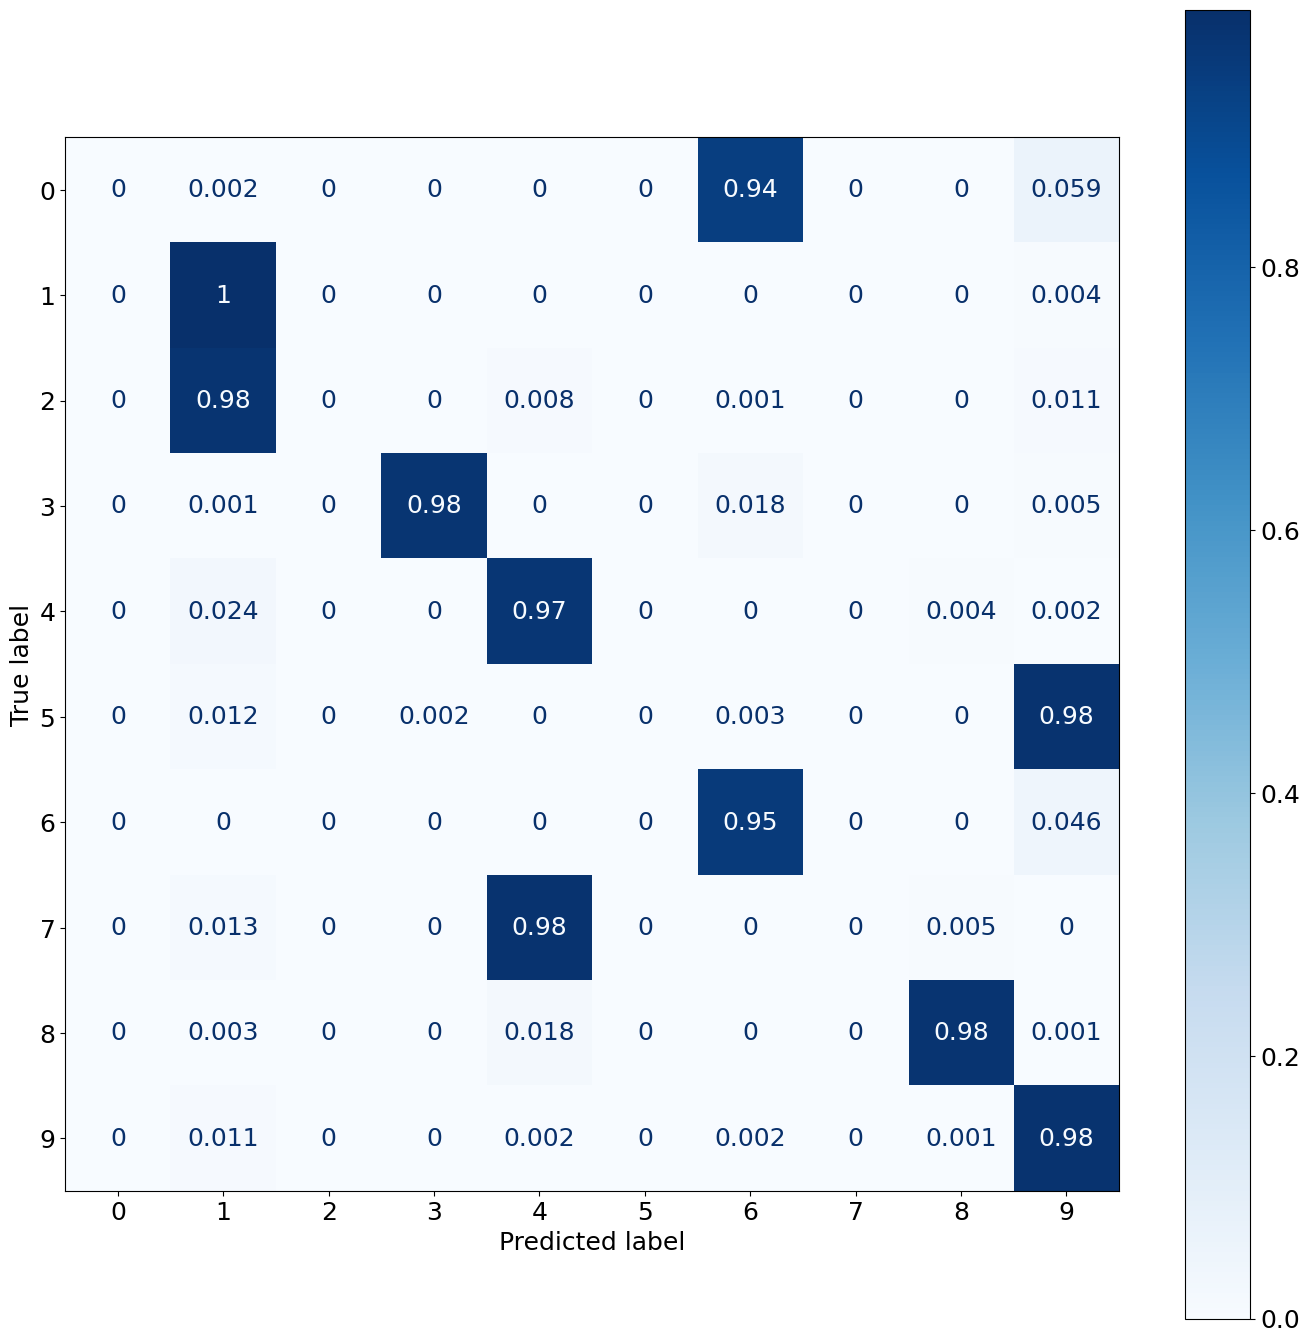

In [16]:
fig, ax = pyplot.subplots(figsize=(17,17))

cm = confusion_matrix(df['gt'], df['pred'], normalize='true')
cm = np.round(cm, 4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=pyplot.cm.Blues, ax=ax)
